In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from numba import njit, prange, cuda
from tqdm import tqdm

In [2]:
# network constants
num_nodes_arr = [80] #, 100, 120, 140, 180]
degree = 3
networks = [nx.to_numpy_array(nx.random_regular_graph(degree, num_nodes)) for num_nodes in num_nodes_arr]

# Local Average and Information Exchange (LAIE) algorithm

In [3]:
@njit
def get_W(adjacency_matrix: np.ndarray) -> np.ndarray:
	'''
	Generate edge weights for LAIE given the adjacency matrix
	'''
	num_nodes = adjacency_matrix.shape[0]
	diagonal_matrix = np.diag(np.sum(adjacency_matrix, axis=0))
	laplacian = diagonal_matrix - adjacency_matrix
	adjacency_with_self = adjacency_matrix + np.eye(num_nodes)

	neighbors_with_self = []
	for i in range(num_nodes):
		neighbors_with_self.append(np.nonzero(adjacency_with_self[i])[0])

	neighbors = []
	for i in range(num_nodes):
		neighbors.append(np.nonzero(adjacency_matrix[i])[0])

	W = np.zeros((num_nodes, num_nodes, num_nodes), dtype=np.float32)

	for i in range(num_nodes):
		for j in range(num_nodes):
			for k in range(num_nodes):
				if j not in neighbors_with_self[i] and k == j:
					W[i, j, k] = 1
				elif (j in neighbors_with_self[i] and k in neighbors_with_self[i]) or (i == j and j == k and i == k):
					W[i, j, k] = 1 / len(neighbors_with_self[i])
				else:
					W[i, j, k] = 0

	return W

In [4]:
@njit(parallel=True)
def LAIE(W: np.ndarray, x_0: np.ndarray, timesteps=100, runs=100, epsilon=0.01):
	num_nodes = W.shape[0]
	x_history = np.zeros((runs, num_nodes, timesteps), dtype=np.float32)

	for run in prange(runs):
		x_history[run, :, 0] = x_0[run]

		for t in range(1, timesteps):
			# i = t % num_nodes
			x_history[run, :, t] = x_history[run, :, t - 1]
			for i in range(num_nodes):
				x_history[run, :, t] = W[i] @ x_history[run, :, t]

	return x_history

In [5]:
@njit(parallel=True)
def distributed_averaging(W: np.ndarray, x_0: np.ndarray, timesteps=100, runs=100):
	num_nodes = W.shape[0]
	x_history = np.zeros((runs, num_nodes, timesteps))

	for run in prange(runs):
		x_history[run, :, 0] = x_0[run]

		for t in range(1, timesteps):
			x_history[run, :, t] = W @ x_history[run, :, t - 1]

	return x_history

0it [00:00, ?it/s]/tmp/ipykernel_7843/957965973.py:13: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float32, 2, 'C', False, aligned=True), Array(float32, 1, 'A', False, aligned=True))
  x_history[run, :, t] = W[i] @ x_history[run, :, t]
/home/monish/Documents/GitHub/mamab-jit/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/tmp/ipykernel_7843/957965973.py:13: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float32, 2, 'C', False, aligned=True), Array(float32, 1, 'A', False, aligned=True))
  x_history[run, :, t] = W[i] @ x_history[run, :, t]
/tmp/ipykernel_7843/3404284533.py:10: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True

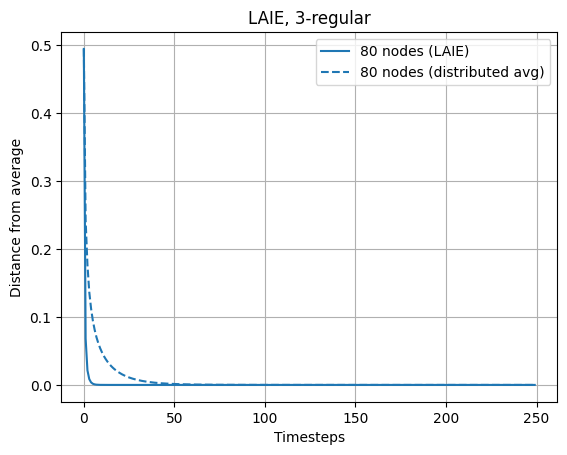

In [6]:
for networkIdx, adjacency_matrix in tqdm(enumerate(networks)):
	runs = 500
	timesteps = 250
	num_nodes_in_network = adjacency_matrix.shape[0]

	# generate random initial states for each run
	initial_states = np.array([np.random.randint(0, 2, num_nodes_in_network) for _ in range(runs)])
	avg_states = np.mean(initial_states, axis=1)
	W = get_W(adjacency_matrix)

	x_history = LAIE(W, initial_states, timesteps=timesteps, runs=runs, epsilon=0.01)

	# calculate the distance of each node from the average in every run,
	# then average over runs and nodes
	error_history = np.zeros_like(x_history)
	for run in range(runs):
		error_history[run] = np.abs(avg_states[run] - x_history[run])
	error_history = np.mean(error_history, axis=(0, 1)) # average over runs and nodes

	plt.plot(error_history, label=f'{num_nodes_in_network} nodes (LAIE)')
	plt.gca().set_prop_cycle(None)

	W = (1 / np.sum(adjacency_matrix, axis=0)) * adjacency_matrix
	x_history = distributed_averaging(W, initial_states, timesteps=timesteps, runs=runs)
	error_history = np.zeros_like(x_history)
	for run in range(runs):
		error_history[run] = np.abs(avg_states[run] - x_history[run])
	error_history = np.mean(error_history, axis=(0, 1)) # average over runs and nodes

	plt.plot(error_history, label=f'{num_nodes_in_network} nodes (distributed avg)', linestyle='--')
	
plt.xlabel('Timesteps')
plt.ylabel('Distance from average')
plt.grid()
plt.legend()
plt.title(f'LAIE, {degree}-regular')
plt.show()

# Multi Agent Multi Armed Bandit (MAMAB) simulation with LAIE

In [7]:
from lmsc import coopucb2
from graph_optimization import fdla_weights_symmetric, fmmc_weights, lmsc_weights, fastest_averaging_constant_weight, max_degree_weights, metropolis_hastings_weights

import cProfile
import pstats

In [8]:
@njit(parallel=True)
def MAMAB_LAIE(W: np.ndarray, true_means: np.ndarray, timesteps=100, runs=100, epsilon=1, min_epsilon=0.01, decay=0.9) -> tuple[np.ndarray, np.ndarray]:
	num_nodes = W.shape[0]
	num_arms = true_means[0].shape[0]
	sigma = 1

	regret_history = np.zeros((runs, num_nodes, timesteps))

	arms_pulled_snapshot = np.zeros(num_arms)

	for run in prange(runs):
		cumulative_estimated_reward = np.zeros((num_nodes, num_arms), dtype=np.float32)
		cumulative_estimated_pulls = np.zeros((num_nodes, num_arms), dtype=np.float32)
		for t in range(timesteps):
			current_reward_vector = np.zeros((num_nodes, num_arms), dtype=np.float32)
			current_pulls = np.zeros((num_nodes, num_arms), dtype=np.float32)

			# if t < num_arms:
			# 	for k in range(num_nodes):
			# 		action = t
			# 		current_reward_vector[k, action] = np.random.normal(true_means[run, action], sigma)
			# 		current_pulls[k, action] += 1
			# 		regret_history[run, k, t] = np.max(true_means[run]) - true_means[run, action]
			# else:
			for k in range(num_nodes):
				# epsilon greedy
				action = np.random.randint(0, num_arms) if np.random.rand() < epsilon else np.argmax(cumulative_estimated_reward[k] / cumulative_estimated_pulls[k])
				current_reward_vector[k, action] = np.random.normal(true_means[run, action], sigma)
				current_pulls[k, action] += 1
				regret_history[run, k, t] = np.max(true_means[run]) - true_means[run, action]

			# if run == 0:
			# 	arms_pulled_snapshot[action] += 1

			# decay epsilon
			if epsilon > min_epsilon:
				# epsilon *= decay
				epsilon = 1 / np.sqrt(t + 1)

			# exchange information using LAIE algorithm
			for i in range(num_arms):
				for k in range(num_nodes):
					cumulative_estimated_reward[:, i] = W[k] @ (cumulative_estimated_reward[:, i] + current_reward_vector[:, i])
					cumulative_estimated_pulls[:, i] = W[k] @ (cumulative_estimated_pulls[:, i] + current_pulls[:, i])


	return regret_history, arms_pulled_snapshot

In [9]:
# @njit
def get_optimized_W(adjacency_matrix: np.ndarray, method: str = 'fdla') -> np.ndarray:
	'''
	Generate optimized edge weights for LAIE given the adjacency matrix and optimization method

	Methods:
	1. `max`: Maximum degree weights
	2. `constant`: Best constant weights
	3. `local`: Local degree weights (Metropolis-Hastings)
	4. `fmmc`: Fastest Mixing Markov Chain
	5. `fdla`: Fastest Distributed Linear Averaging [default]
	'''
	num_nodes = adjacency_matrix.shape[0]
	diagonal_matrix = np.diag(np.sum(adjacency_matrix, axis=0))
	laplacian = diagonal_matrix - adjacency_matrix
	adjacency_with_self = adjacency_matrix + np.eye(num_nodes)

	optimization_funcs = {
		'max': max_degree_weights,
		'constant': fastest_averaging_constant_weight,
		'local': metropolis_hastings_weights,
		'fmmc': fmmc_weights,
		'fdla': fdla_weights_symmetric,
	}

	global_optimized_W = optimization_funcs[method](adjacency_matrix)
	print(global_optimized_W)

	neighbors_with_self = []
	for i in range(num_nodes):
		neighbors_with_self.append(np.nonzero(adjacency_with_self[i])[0])

	neighbors = []
	for i in range(num_nodes):
		neighbors.append(np.nonzero(adjacency_matrix[i])[0])

	W = np.zeros((num_nodes, num_nodes, num_nodes), dtype=np.float32)

	for i in range(num_nodes):
		for j in range(num_nodes):
			for k in range(num_nodes):
				if j not in neighbors_with_self[i] and k == j:
					W[i, j, k] = 1
				elif (j in neighbors_with_self[i] and k in neighbors_with_self[i]) or (i == j and j == k and i == k):
					W[i, j, k] = 1 / len(neighbors_with_self[i])
				else:
					W[i, j, k] = 0

	return W

In [10]:
# mamab constants
runs = 1000
timesteps = 2000
# num_arms = 100

num_nodes_arr = [80] # , 100, 120, 140, 180]
degree = 3
# networks = [nx.to_numpy_array(nx.random_regular_graph(degree, num_nodes)) for num_nodes in num_nodes_arr]
networks = [
    # house
	np.array([
		[0, 1, 1, 0, 0],
		[1, 0, 1, 1, 0],
		[1, 1, 0, 0, 1],
		[0, 1, 0, 0, 1],
		[0, 0, 1, 1, 0],
	]),
]

In [11]:
# # %matplotlib widget
# plt.cla()
# for networkIdx, adjacency_matrix in enumerate(networks):
# 	num_nodes_in_network = adjacency_matrix.shape[0]

# 	print('running LAIE...')
# 	W = get_W(adjacency_matrix)

# 	regret_history, snap = MAMAB_LAIE(W, true_means, timesteps=timesteps, runs=runs, epsilon=1, min_epsilon=0.01, decay=0.99)
# 	print(snap)

# 	regret_history = np.cumsum(regret_history, axis=2)
# 	regret = np.mean(regret_history, axis=(0, 1)) # average over runs and nodes
# 	plt.plot(regret, label=f'LAIE, {num_nodes_in_network} nodes')
# 	print('done.')

# 	print('running CoopUCB2...')
# 	_, _, best_constant_W, _ = fastest_averaging_constant_weight(np.asarray(nx.linalg.graphmatrix.incidence_matrix(nx.from_numpy_array(adjacency_matrix), oriented=True).todense()))
# 	coopucb2_regret, snap = coopucb2(runs, num_arms, timesteps, true_means, best_constant_W)
# 	coopucb2_regret = np.cumsum(coopucb2_regret, axis=2)
# 	coopucb2_regret = np.mean(coopucb2_regret, axis=(0, 1)) # average over runs and nodes
# 	plt.plot(coopucb2_regret, label=f'CoopUCB2, {num_nodes_in_network} nodes')
# 	print('done.')

# plt.xlabel('Timesteps')
# plt.ylabel('Regret')
# # plt.xlim(left=200)
# # plt.ylim(bottom=500)
# plt.title('House network, 10 arms')
# plt.grid()
# plt.legend()
# plt.show()

100%|██████████| 7/7 [01:16<00:00, 10.87s/it]


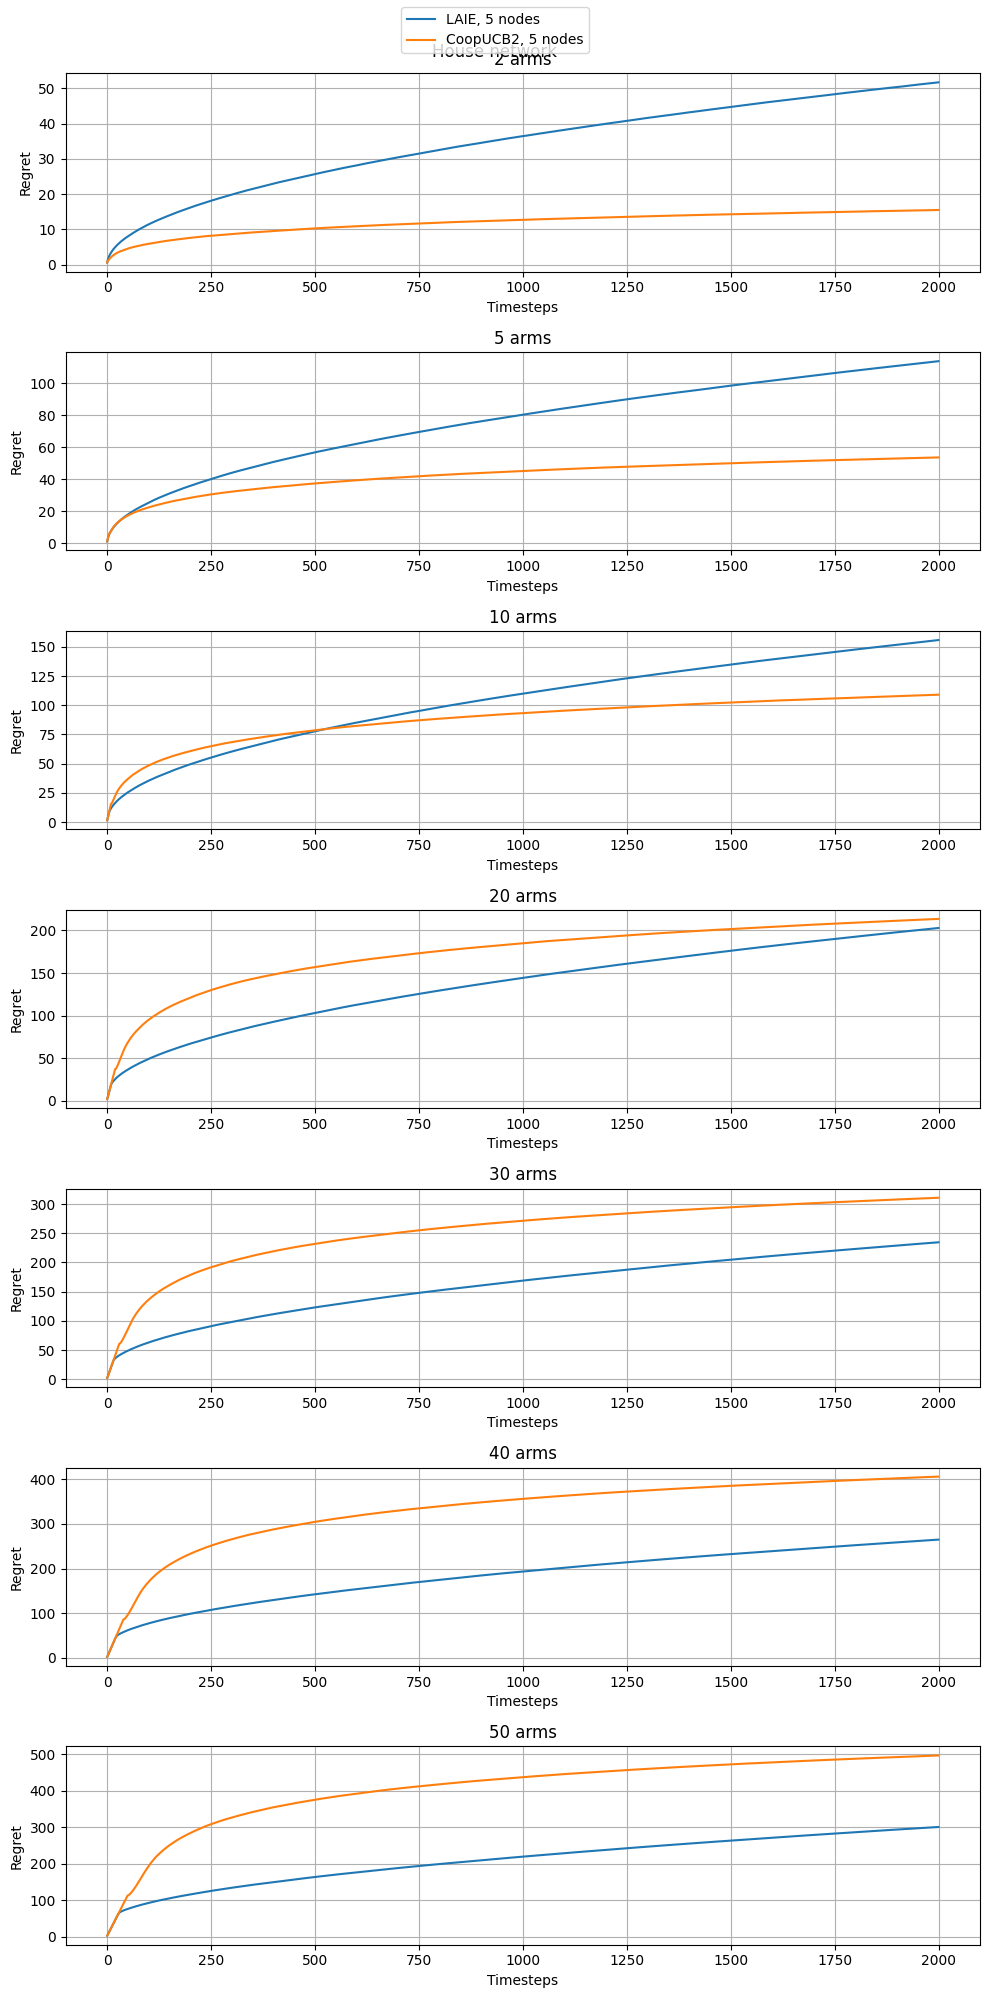

In [12]:
# %matplotlib widget
arm_counts_arr = np.array([2, 5, 10, 20, 30, 40, 50])

# subplots for each arm count
fig, ax = plt.subplots(arm_counts_arr.shape[0], 1, figsize=(10, 20))

for arm_count_idx, arm_count in enumerate(tqdm(arm_counts_arr)):
	true_means = np.array([np.random.normal(0, 1, arm_count) for _ in range(runs)])
	# true_means = np.sort(true_means, axis=1)[:, ::-1]

	for networkIdx, adjacency_matrix in enumerate(networks):
		num_nodes_in_network = adjacency_matrix.shape[0]

		# print('running LAIE...')
		W = get_W(adjacency_matrix)

		regret_history, snap = MAMAB_LAIE(W, true_means, timesteps=timesteps, runs=runs, epsilon=1, min_epsilon=0.01, decay=0.99)

		regret_history = np.cumsum(regret_history, axis=2)
		regret = np.mean(regret_history, axis=(0, 1)) # average over runs and nodes
		ax[arm_count_idx].plot(regret, label=f'LAIE, {num_nodes_in_network} nodes')
		# print('done.')

		# print('running CoopUCB2...')
		_, _, best_constant_W, _ = fastest_averaging_constant_weight(np.asarray(nx.linalg.graphmatrix.incidence_matrix(nx.from_numpy_array(adjacency_matrix), oriented=True).todense()))
		coopucb2_regret, snap = coopucb2(runs, arm_count, timesteps, true_means, best_constant_W)
		coopucb2_regret = np.cumsum(coopucb2_regret, axis=2)
		coopucb2_regret = np.mean(coopucb2_regret, axis=(0, 1)) # average over runs and nodes
		ax[arm_count_idx].plot(coopucb2_regret, label=f'CoopUCB2, {num_nodes_in_network} nodes')
		# print('done.')

		ax[arm_count_idx].set_xlabel('Timesteps')
		ax[arm_count_idx].set_ylabel('Regret')
		# ax[arm_count_idx].set_xlim(left=200)
		# ax[arm_count_idx].set_ylim(bottom=500)
		ax[arm_count_idx].set_title(f'{arm_count} arms')
		ax[arm_count_idx].grid(True)
		# ax[arm_count_idx].legend()

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
fig.suptitle('House network')
fig.tight_layout()
plt.show()

In [13]:
print(W, end='\n\n\n\n')
print(fdla_weights_symmetric(np.asarray(nx.linalg.graphmatrix.incidence_matrix(nx.from_numpy_array(adjacency_matrix), oriented=True).todense()))[1])

[[[0.33333334 0.33333334 0.33333334 0.         0.        ]
  [0.33333334 0.33333334 0.33333334 0.         0.        ]
  [0.33333334 0.33333334 0.33333334 0.         0.        ]
  [0.         0.         0.         1.         0.        ]
  [0.         0.         0.         0.         1.        ]]

 [[0.25       0.25       0.25       0.25       0.        ]
  [0.25       0.25       0.25       0.25       0.        ]
  [0.25       0.25       0.25       0.25       0.        ]
  [0.25       0.25       0.25       0.25       0.        ]
  [0.         0.         0.         0.         1.        ]]

 [[0.25       0.25       0.25       0.         0.25      ]
  [0.25       0.25       0.25       0.         0.25      ]
  [0.25       0.25       0.25       0.         0.25      ]
  [0.         0.         0.         1.         0.        ]
  [0.25       0.25       0.25       0.         0.25      ]]

 [[1.         0.         0.         0.         0.        ]
  [0.         0.33333334 0.         0.33333334 0.3